#### Importing all necessary libraries

In [1]:
from IPython.display import Audio, display
import IPython.display as ipd

import librosa
from librosa import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import load_model


#### Function for loading dataset

In [2]:
def load_dataset(path):
    """Loads dataset from path provided and return pandas object"""
    ds_path= path
    ds= pd.read_csv(ds_path)
    return ds

#### Function for loading audios using librosa

In [3]:
def audio_signals(path, sample_rate=16000, duration=3):
    """Loading audio using librosa library"""
    audio, sr= librosa.load(path, sr=sample_rate, duration=duration, mono=True)
    if sr!=sample_rate:
        audio = librosa.resample(audio, sr, sample_rate)
    return audio

def load_audio_signals(ds, num_of_samples):
    """Returns numpya array of all audio signals"""
    all_audio_signals=[]

    for path in ds['file_path']:
        audio= audio_signals("./Dataset-2/"+path)
        all_audio_signals.append(audio)
        if(len(all_audio_signals)==num_of_samples):
            break

    all_audio_signals= np.array(all_audio_signals, dtype=object)
    return all_audio_signals


#### Data augmentation (Data Pre-processing)

In [28]:
import numpy as np
import librosa
import random

def add_noise(audio, noise_factor=0.005):
    """Add random noise to the audio signal"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_stretch(audio, rate=1.2):
    """Stretch or compress the audio in time without changing pitch"""
    augmented_audio = librosa.effects.time_stretch(y=audio, rate=rate)
    return augmented_audio

def pitch_shift(audio, sr, n_steps=2):
    """Shift the pitch of the audio signal"""
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return augmented_audio

def time_shift(audio, sr, shift_factor=0.2):
    """Shift the audio signal in time"""
    shift_samples = int(shift_factor * len(audio))
    augmented_audio = np.roll(audio, shift_samples)
    return augmented_audio

def apply_augmentation(audio, sr=16000):
    """Apply random augmentation to the audio signal"""
    # augmentation_functions = [add_noise, time_stretch, pitch_shift, time_shift]
    # augmentation_functions = [add_noise, time_stretch, pitch_shift, lambda x: time_shift(x, sr)]
    augmentation_functions = [add_noise, time_stretch, lambda x, sr=sr: pitch_shift(x, sr), lambda x, sr=sr: time_shift(x, sr)]
    augmentation_function = random.choice(augmentation_functions)
    augmented_audio = augmentation_function(audio)
    return augmented_audio

def augment_audios(audios):
    """Apply augmentation to a list of audio signals"""
    augmented_audios = []
    for audio in audios:
        augmented_audio = apply_augmentation(audio)
        augmented_audios.append(augmented_audio)
    return np.array(augmented_audios, dtype= object)


#### Label encoding for speakers

In [5]:
def label_encoding(ds, num_of_samples):
    """Label encoding of speakers for classification"""
    labels=[]

    for label in ds['speaker']:
        labels.append(label)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit and transform the labels
    y_encoded = label_encoder.fit_transform(labels)

    # Print the mapping between original labels and encoded values
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label Mapping:", label_mapping)
    y_encoded=y_encoded[0:num_of_samples]
    return y_encoded

#### Fourier Magnitude Spectra- Feature Extraction

In [6]:
def feature_extraction(all_audio_signals, num_of_samples):
    """Returns the fourier magnitude spectrum as feature vector"""
    fourier_magnitude=[]
    fixed_num_freq_samples = 24001

    for audio in all_audio_signals[0:num_of_samples]:
        fourier = np.fft.rfft(audio)
        sampling_rate = 16000.0

        num_freq_samples = len(fourier)
        resampled_fourier = np.interp(np.linspace(0, num_freq_samples - 1, fixed_num_freq_samples), np.arange(num_freq_samples), fourier)
        N = len(audio)
        normalize = N/2
        norm_amplitude = np.abs(resampled_fourier)/normalize
        fourier_magnitude.append(norm_amplitude)


    fourier_magnitude= np.array(fourier_magnitude, dtype=float)

    return fourier_magnitude


#### For Training

In [7]:
ds= load_dataset("./Dataset-2/train.csv")

In [84]:
num_of_samples= 3000
audios= load_audio_signals(ds, num_of_samples)
encoded_y= label_encoding(ds,num_of_samples)
print(audios)
print(audios.shape)

Label Mapping: {'aew': 0, 'ahw': 1, 'aup': 2, 'awb': 3, 'axb': 4, 'bdl': 5, 'clb': 6, 'eey': 7, 'fem': 8, 'gka': 9, 'jmk': 10, 'ksp': 11, 'ljm': 12, 'lnh': 13, 'rms': 14, 'rxr': 15, 'slp': 16, 'slt': 17}
[array([0.00521851, 0.0062561 , 0.00543213, ..., 0.        , 0.        ,
        0.        ], dtype=float32)
 array([0.00094604, 0.00115967, 0.00067139, ..., 0.01141357, 0.01730347,
        0.00491333], dtype=float32)
 array([-0.00115967, -0.00143433, -0.00137329, ..., -0.00183105,
        -0.00195312, -0.00183105], dtype=float32)                ...
 array([ 0.00012207,  0.00012207,  0.00039673, ...,  0.06216431,
         0.0015564 , -0.02697754], dtype=float32)
 array([-0.0005188 , -0.0005188 , -0.00048828, ...,  0.        ,
         0.        ,  0.        ], dtype=float32)
 array([-0.00430298, -0.00424194, -0.00469971, ..., -0.0007019 ,
        -0.00048828, -0.0007019 ], dtype=float32)               ]
(3000,)


In [85]:
augmented_audios = augment_audios(audios)
print(augmented_audios)
print(augmented_audios.shape)

[array([-0.05493164, -0.05148315, -0.04650879, ..., -0.05032349,
        -0.05447388, -0.05737305], dtype=float32)
 array([ 0.00094406,  0.00106522,  0.00078033, ..., -0.00802859,
        -0.00226684,  0.00577904], dtype=float32)
 array([ 0.00704814, -0.00129165, -0.00388875, ..., -0.00016747,
        -0.00443582, -0.00039775])                               ...
 array([7.3119605e-05, 1.9680563e-04, 3.4200089e-04, ..., 2.4078891e-03,
        5.7600420e-03, 3.1722693e-03], dtype=float32)
 array([-0.0004702 , -0.00052782, -0.00049365, ..., -0.00030277,
        -0.00027932, -0.00032359], dtype=float32)
 array([-4.2791897e-03, -4.2221909e-03, -4.6514133e-03, ...,
         1.2576625e-04,  2.8581971e-05, -3.3309010e-05], dtype=float32)]
(3000,)


In [31]:
features= feature_extraction(augmented_audios,num_of_samples)

#### For Testing

In [32]:
test_ds= load_dataset("./Dataset-2/test_full.csv")
test_audios= load_audio_signals(test_ds,num_of_samples)
encoded_y_test= label_encoding(test_ds,num_of_samples)
features_y= feature_extraction(test_audios,num_of_samples)

Label Mapping: {'aew': 0, 'ahw': 1, 'aup': 2, 'awb': 3, 'axb': 4, 'bdl': 5, 'clb': 6, 'eey': 7, 'fem': 8, 'gka': 9, 'jmk': 10, 'ksp': 11, 'ljm': 12, 'lnh': 13, 'rms': 14, 'rxr': 15, 'slp': 16, 'slt': 17}


### Plots of augmented audios

<Figure size 640x480 with 0 Axes>

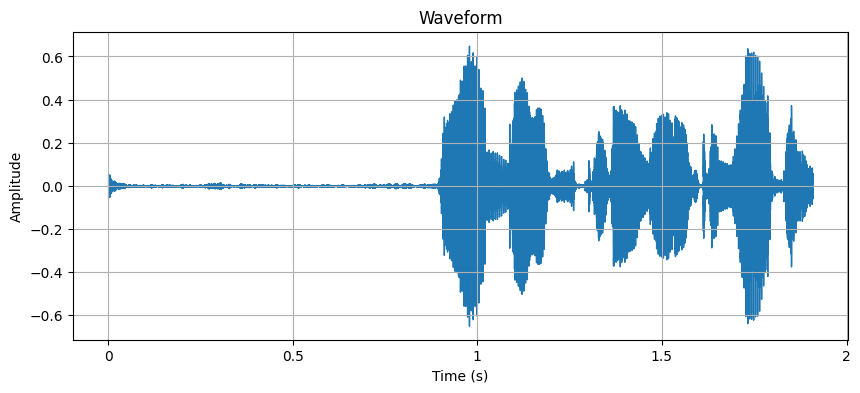

<Figure size 640x480 with 0 Axes>

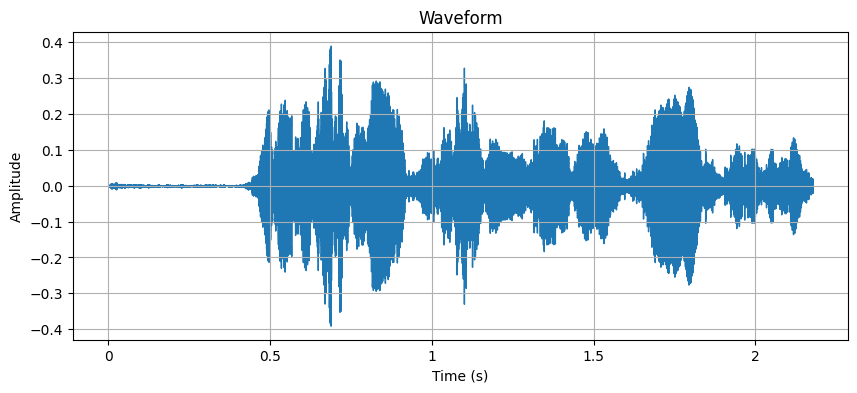

In [86]:
# plotting first 2 signals

for i in range(2):
    plt.figure()
    #plot the raw audio signal using librosa
    plt.figure(figsize=(10,4))
    librosa.display.waveshow(augmented_audios[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.grid()
    plt.show()

For speaker 0


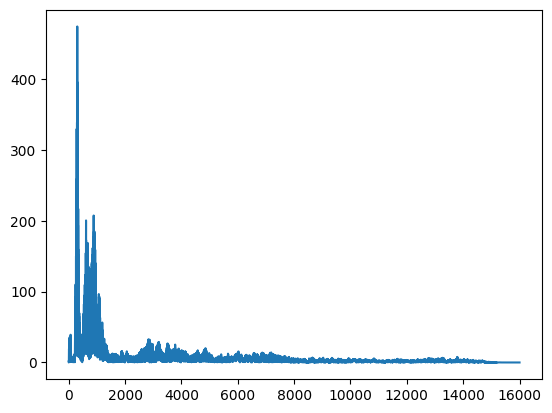

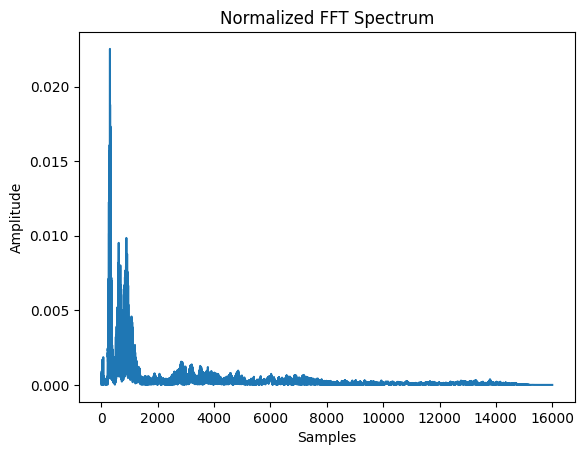

For speaker 1


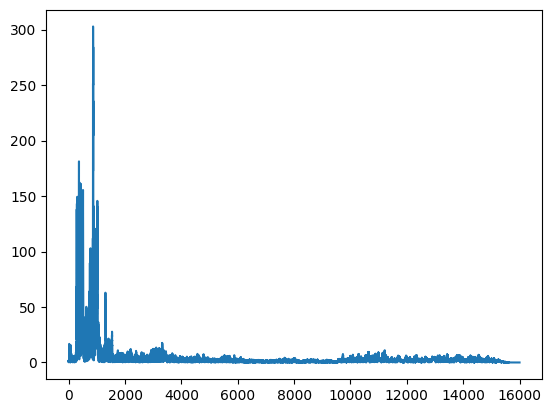

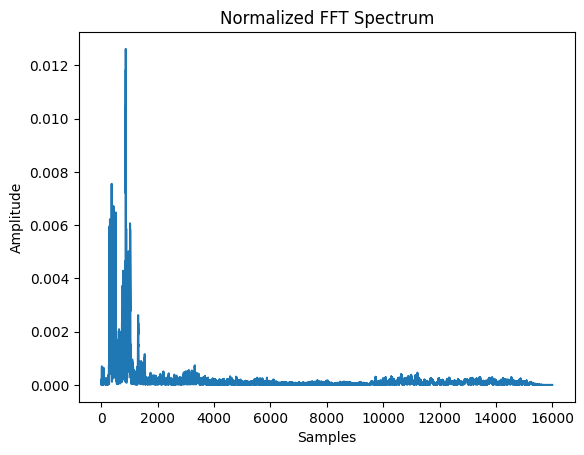

In [87]:
for i in range(2):
    print(f"For speaker {i}")
    fourier = np.fft.rfft(augmented_audios[i])
    # Get the frequency components of the spectrum
    sampling_rate = 16000.0 # It's used as a sample spacing
    frequency_axis = np.linspace(0, sampling_rate, len(np.abs(fourier)))
    plt.figure()
    # Plot the result (the spectrum |Xk|)
    plt.plot(frequency_axis,np.abs(fourier))
    plt.show()

    # Calculate N/2 to normalize the FFT output
    N = len(audios[i])
    normalize = N/2

    plt.figure()
    # Plot the normalized FFT (|Xk|)/(N/2)
    plt.plot(frequency_axis,np.abs(fourier)/normalize)
    plt.ylabel('Amplitude')
    plt.xlabel('Samples')
    plt.title('Normalized FFT Spectrum')
    plt.show()

### Machine Learning: Logistic Regression

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features, encoded_y, test_size = 0.3, random_state = 0)

In [36]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [37]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

#### TESTING

In [38]:
print(classifier.predict(sc.transform(features_y)))
y_pred=classifier.predict(sc.transform(features_y))

[ 7  7  3 ... 11  7 15]


In [39]:
y_test=encoded_y_test
print(y_test)

[ 0  7  3 ... 11  7 15]


In [40]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy", accuracy_score(y_pred, y_test))

[[172   4   2   1   7   3   1   6   5   0   1   2   0   4   4   4   2   1]
 [  0 106   0   0   0   0   0   0   1   0   0   4   0   0   0   2   0   0]
 [  0   0 112   0   4   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 213   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 111   0   0   1   0   0   0   0   0   1   0   0   1   1]
 [  1   1   3   7   1 195   0   2   1   0   2   1   0   3   0   0   0   0]
 [  0   0   0   0   0   1 211   0   0   0   0   0   0   0   0   0   0   8]
 [  0   1   0   0   1   3   1  90   0   0   0   0   3   2   0   0  12   1]
 [  0   0   0   0   1   0   0   0 113   0   0   0   0   0   0   0   0   0]
 [ 16   0   0   0   0   0   0   0   0  91   2   5   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0 218   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0 217   0   0   0   0   1   0]
 [  0   0   0   0   3   0   2   3   0   0   0   0  78   8   0   0  18   3]
 [  1   0   0   0   0   8

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       219
           1       0.88      0.94      0.91       113
           2       0.93      0.96      0.94       117
           3       0.96      1.00      0.98       213
           4       0.84      0.97      0.90       115
           5       0.92      0.90      0.91       217
           6       0.96      0.96      0.96       220
           7       0.85      0.79      0.82       114
           8       0.92      0.99      0.95       114
           9       0.99      0.79      0.88       115
          10       0.96      1.00      0.98       218
          11       0.92      0.99      0.96       219
          12       0.86      0.68      0.76       115
          13       0.90      0.92      0.91       218
          14       0.98      0.97      0.97       212
          15       0.94      0.81      0.87       129
          16       0.73      0.88      0.80       114
          17       0.92    

In [42]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(18):
     prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                  np.array(y_pred)==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,0,0.991370,0.785388
1,1,0.995151,0.938053
2,2,0.996878,0.957265
3,3,0.996771,1.000000
4,4,0.992721,0.965217
5,5,0.994251,0.898618
6,6,0.997122,0.959091
7,7,0.994456,0.789474
8,8,0.996535,0.991228
9,9,0.999653,0.791304


### 1D CNN without Windowing

In [43]:
X_train, X_temp, y_train, y_temp = train_test_split(features, encoded_y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train.astype('float32')
y_train = y_train.astype('int32')
X_val = X_val.astype('float32')
y_val = y_val.astype('int32')
X_test = X_test.astype('float32')
y_test = y_test.astype('int32')

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)

print("Training y Data Shape:", y_train.shape)
print("Validation y Data Shape:", y_val.shape)
print("Test y Data Shape:", y_test.shape)

Training Data Shape: (2100, 24001)
Validation Data Shape: (450, 24001)
Test Data Shape: (450, 24001)
Training y Data Shape: (2100,)
Validation y Data Shape: (450,)
Test y Data Shape: (450,)


In [45]:
# Reshape the input data for compatibility with Conv1D
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Convert labels to one-hot encoded format
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)

# Defining the CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train_reshaped, y_train_encoded, validation_data=(X_val_reshaped, y_val_encoded), epochs=20, batch_size=32)

model.save("1d_cnn_model_without_window_new.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 23999, 64)         256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 11999, 64)        0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 11997, 128)        24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5998, 128)        0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 767744)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

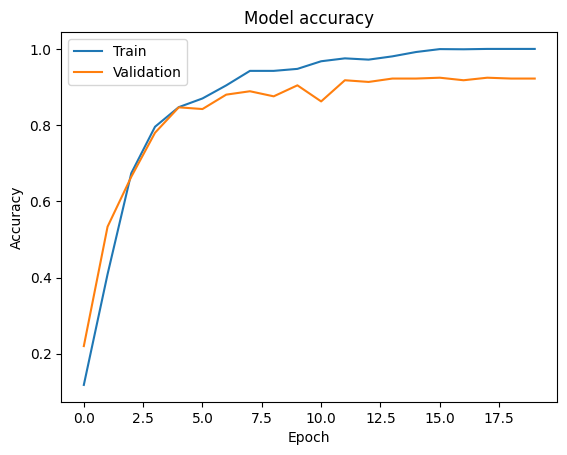

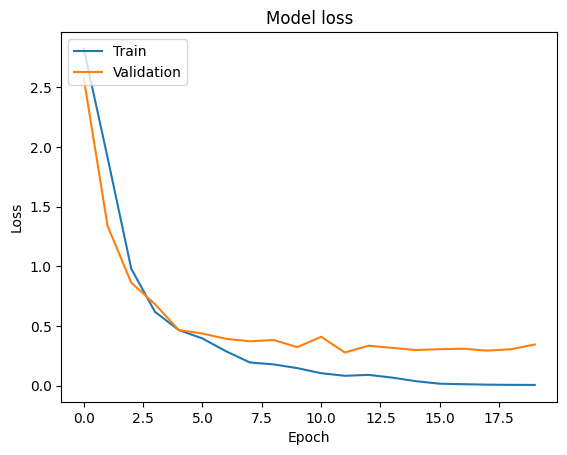

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### TESTING

In [66]:
loaded_model = load_model("1d_cnn_model_without_window_new.h5")

X_test_reshaped = features_y.reshape(features_y.shape[0], features_y.shape[1], 1)

y_pred = loaded_model.predict(X_test_reshaped)

94/94 [==============================] - 46s 491ms/step


In [67]:
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

[ 0  7  3 ... 11  7 15]


In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(encoded_y_test, y_pred_classes)
print(cm)
accuracy_score(encoded_y_test, y_pred_classes)

[[193   0   3   0   0   0   0   0   6   2   1   6   0   0   8   0   0   0]
 [  0 105   0   1   0   0   0   0   0   0   0   7   0   0   0   0   0   0]
 [  1   0 113   1   0   1   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0 213   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0  91   0   0   3   0   0   0   0   8   2   0   0   6   3]
 [  0   1  14   6   0 182   0   0  12   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0 212   0   0   0   0   0   0   0   0   0   0   8]
 [  0   0   0   0   0   0   3  96   0   0   0   0   2   0   0   0   8   5]
 [  0   0   0   0   0   0   0   0 106   0   0   0   0   0   8   0   0   0]
 [  0   0   0   0   0   0   0   0   0 106   8   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 217   0   0   0   1   0   0   0]
 [  3  10   0   0   0   3   0   0   2   5   1 195   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0  10   0   0   0   0  66  14   0   1  13   9]
 [  1   0   3   0   0   0

0.901

In [69]:
from sklearn.metrics import classification_report
print(classification_report(encoded_y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       219
           1       0.86      0.93      0.89       113
           2       0.82      0.97      0.89       117
           3       0.96      1.00      0.98       213
           4       0.96      0.79      0.87       115
           5       0.98      0.84      0.90       217
           6       0.96      0.96      0.96       220
           7       0.70      0.84      0.76       114
           8       0.84      0.93      0.88       114
           9       0.93      0.92      0.93       115
          10       0.95      1.00      0.97       218
          11       0.89      0.89      0.89       219
          12       0.77      0.57      0.66       115
          13       0.91      0.94      0.93       218
          14       0.92      1.00      0.96       212
          15       0.96      0.90      0.93       129
          16       0.71      0.63      0.67       114
          17       0.88    

In [70]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(18):
     prec,recall,_,_ = precision_recall_fscore_support(np.array(encoded_y_test)==l,
                                                  np.array(y_pred_classes)==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,0,0.997843,0.881279
1,1,0.994112,0.929204
2,2,0.991675,0.965812
3,3,0.996412,1.000000
4,4,0.998614,0.791304
5,5,0.998563,0.838710
6,6,0.997122,0.963636
7,7,0.985793,0.842105
8,8,0.993070,0.929825
9,9,0.997227,0.921739


### 1D CNN with hamming window

In [71]:
def apply_window(audio, window_type="hamming"):
    if window_type == "hamming":
        window = np.hamming(len(audio))
    else:
        raise ValueError("Invalid window type. Supported type is 'hamming'.")
    
    # Apply the window to the audio signal
    windowed_audio = audio * window
    return windowed_audio

In [72]:
augmented_audios=[apply_window(audio, window_type="hamming") for audio in augmented_audios] 
features= feature_extraction(augmented_audios,num_of_samples)

### Plots with windowed audios

<Figure size 640x480 with 0 Axes>

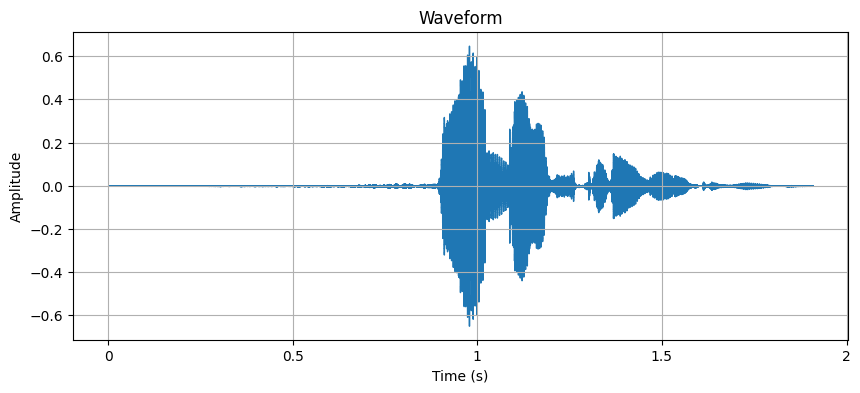

<Figure size 640x480 with 0 Axes>

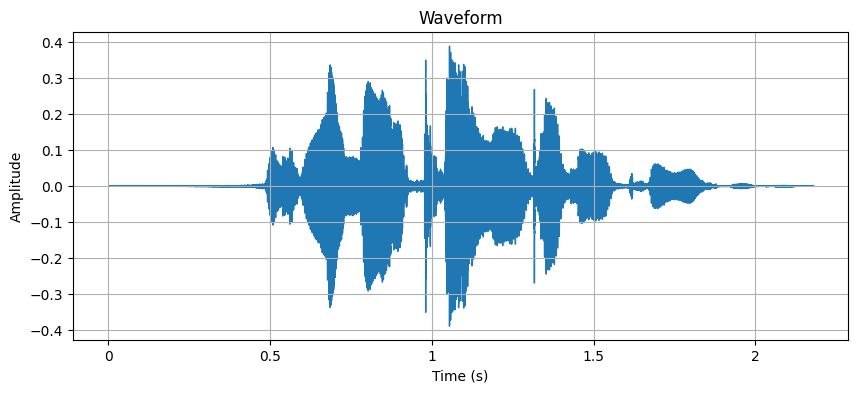

In [73]:
for i in range(2):
    plt.figure()
    #plot the raw audio signal using librosa
    plt.figure(figsize=(10,4))
    librosa.display.waveshow(augmented_audios[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.grid()
    plt.show()

For speaker 0


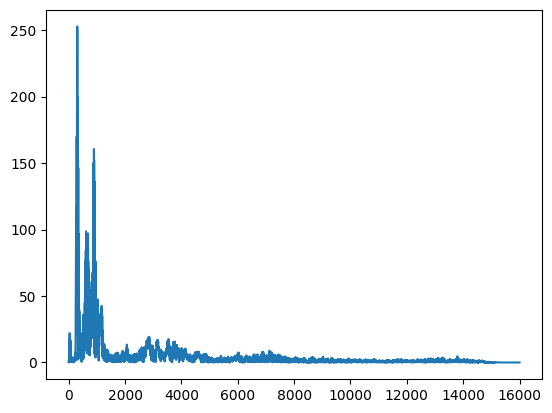

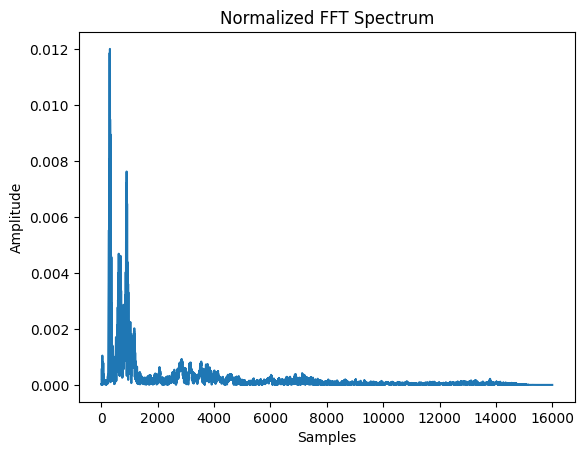

For speaker 1


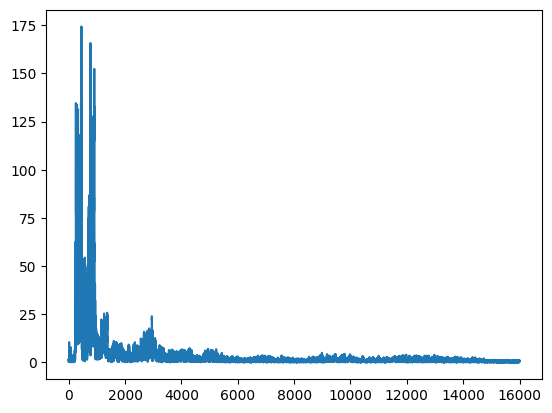

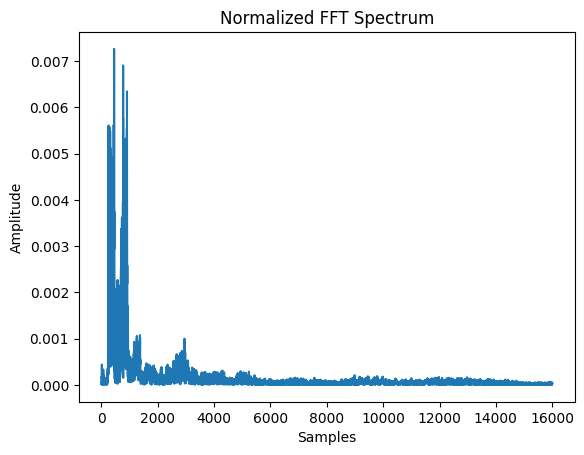

In [74]:
for i in range(2):
    print(f"For speaker {i}")
    fourier = np.fft.rfft(augmented_audios[i])
    # Get the frequency components of the spectrum
    sampling_rate = 16000.0 # It's used as a sample spacing
    frequency_axis = np.linspace(0, sampling_rate, len(np.abs(fourier)))
    plt.figure()
    # Plot the result (the spectrum |Xk|)
    plt.plot(frequency_axis,np.abs(fourier))
    plt.show()

    # Calculate N/2 to normalize the FFT output
    N = len(audios[i])
    normalize = N/2

    plt.figure()
    # Plot the normalized FFT (|Xk|)/(N/2)
    plt.plot(frequency_axis,np.abs(fourier)/normalize)
    plt.ylabel('Amplitude')
    plt.xlabel('Samples')
    plt.title('Normalized FFT Spectrum')
    plt.show()

In [75]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, encoded_y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


X_train = X_train.astype('float32')
y_train = y_train.astype('int32')
X_val = X_val.astype('float32')
y_val = y_val.astype('int32')
X_test = X_test.astype('float32')
y_test = y_test.astype('int32')

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)

print("Training y Data Shape:", y_train.shape)
print("Validation y Data Shape:", y_val.shape)
print("Test y Data Shape:", y_test.shape)

Training Data Shape: (2100, 24001)
Validation Data Shape: (450, 24001)
Test Data Shape: (450, 24001)
Training y Data Shape: (2100,)
Validation y Data Shape: (450,)
Test y Data Shape: (450,)


In [76]:
# Reshape the input data for compatibility with Conv1D
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Convert labels to one-hot encoded format
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)

# Defining the CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train_reshaped, y_train_encoded, validation_data=(X_val_reshaped, y_val_encoded), epochs=25, batch_size=32)

model.save("1d_cnn_model_hamming_window_new.h5")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 23999, 64)         256       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 11999, 64)        0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 11997, 128)        24704     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 5998, 128)        0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 767744)            0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
model.save("1d_cnn_model_hamming_window_new.h5")

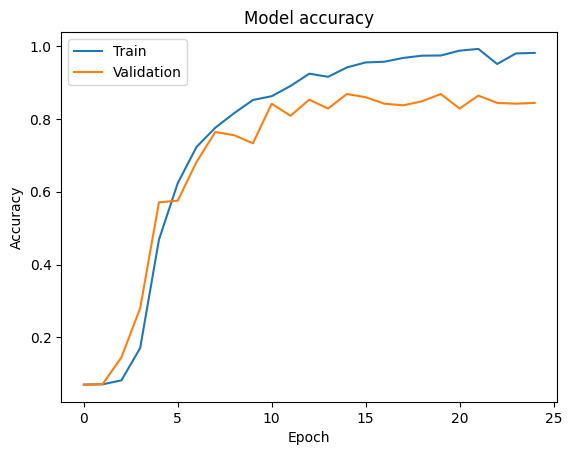

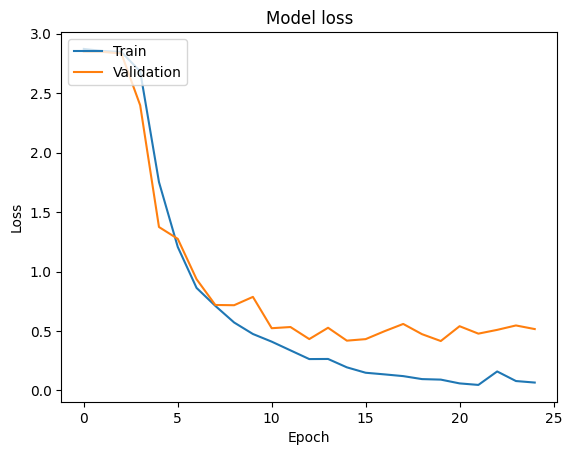

In [77]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### TESTING

In [78]:
test_audios=[apply_window(audio, window_type="hamming") for audio in test_audios] 
features_y= feature_extraction(test_audios,num_of_samples)


In [79]:
loaded_model = load_model("1d_cnn_model_hamming_window_new.h5")

X_test_reshaped = features_y.reshape(features_y.shape[0], features_y.shape[1], 1)

y_pred = loaded_model.predict(X_test_reshaped)

94/94 [==============================] - 40s 422ms/step


In [80]:
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

[ 0  7  3 ... 11 16 15]


In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(encoded_y_test, y_pred_classes)
print(cm)
print("Accuracy:", accuracy_score(encoded_y_test, y_pred_classes))

[[194   0   2   1   0   0   0   0   8   4   1   6   0   0   3   0   0   0]
 [  0  84   0   3   0   0   0   0   1   0   1  21   0   0   0   3   0   0]
 [  1   0 109   5   0   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 209   0   2   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  99   0   0   0   0   0   0   0   1   3   0   0   9   3]
 [  0   1   5   6   0 186   0   0  19   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 209   0   0   1   0   0   0   0   0   0   0  10]
 [  0   0   0   0   0   1  13  64   0   0   0   0   2   0   0   0  26   8]
 [  0   0   0   0   0   0   0   0 110   0   0   0   0   0   4   0   0   0]
 [  1   0   0   0   0   0   0   0   0 108   4   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1 213   0   0   0   4   0   0   0]
 [  4   2   0   1   0   0   0   0   7   7   0 198   0   0   0   0   0   0]
 [  0   0   0   0   7   0   2   5   0   0   0   0  63   5   0   1  25   7]
 [  1   0   7   0   0   2

In [82]:
from sklearn.metrics import classification_report
print(classification_report(encoded_y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       219
           1       0.92      0.74      0.82       113
           2       0.88      0.93      0.90       117
           3       0.92      0.98      0.95       213
           4       0.93      0.86      0.89       115
           5       0.96      0.86      0.91       217
           6       0.91      0.95      0.93       220
           7       0.81      0.56      0.66       114
           8       0.72      0.96      0.82       114
           9       0.89      0.94      0.92       115
          10       0.97      0.98      0.97       218
          11       0.84      0.90      0.87       219
          12       0.88      0.55      0.67       115
          13       0.95      0.84      0.90       218
          14       0.95      0.93      0.94       212
          15       0.93      0.91      0.92       129
          16       0.57      0.84      0.68       114
          17       0.85    

In [83]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(18):
     prec,recall,_,_ = precision_recall_fscore_support(np.array(encoded_y_test)==l,
                                                  np.array(y_pred_classes)==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,0,0.994966,0.885845
1,1,0.997575,0.743363
2,2,0.994797,0.931624
3,3,0.993541,0.981221
4,4,0.997227,0.860870
5,5,0.997485,0.857143
6,6,0.992446,0.950000
7,7,0.994802,0.561404
8,8,0.985100,0.964912
9,9,0.995494,0.939130
